1. 以下关于自动编码器的说法不正确的是：   
A. 自动编码器是一种特征提取技术，还可以用来去噪。   
B. 自动编码器的训练方式属于无监督学习。   
C. 自动编码器得到的编码完整保留了原始输入的信息，从而可以再用解码器还原。   
D. 自动编码器的编码部分和解码部分是一体的，无法分开训练。  

答：  
A.正确。自动编码器学习数据的显著特征，对于噪声，编码器不会将其学习到，就可以实现去噪的效果。
B.正确。自动编码器是无监督学习，通过最小化输入和输出之间的差异进行训练学习。
C.错误。自动编码器编码学习保存到的是压缩的信息，是数据中的显著特征，并不是完整的原始输入信息。
D.正确。在标准的自动编码器中，编码和解码是一体的。但是在其他网络架构中，编码器和解码器往往是拆开在不同的部分分开训练，然后再组成整个网络。

---

2. 自动编码器作为特征提取结构，可以和其他算法组合。将本章的自动编码器提取出的特征输入到MLP里，利用MLP完成有监督的手写数字分类任务。

不同的实现准确率不同

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn

# 导入数据
mnist_train = pd.read_csv("..\mnist_train.csv")
mnist_test = pd.read_csv("..\mnist_test.csv")
# 提取出图像信息，并将内容从0~255的整数转换为0.0~1.0的浮点数
# 图像大小为28*28，数组中每一行代表一张图像
x_train = mnist_train.iloc[:, 1:].to_numpy().reshape(-1, 28 * 28) / 255
x_test = mnist_test.iloc[:, 1:].to_numpy().reshape(-1, 28 * 28) / 255
print(f'训练集大小：{len(x_train)}')
print(f'测试集大小：{len(x_test)}')

训练集大小：60000
测试集大小：10000


In [8]:
# 多层感知机
class MLP(nn.Module):

    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.ModuleList() # ModuleList用列表存储PyTorch模块
        num_in = layer_sizes[0]
        for num_out in layer_sizes[1:]:
            # 创建全连接层
            self.layers.append(nn.Linear(num_in, num_out))
            # 创建逻辑斯谛激活函数层
            self.layers.append(nn.Sigmoid())
            num_in = num_out

    def forward(self, x):
        # 前向传播
        for l in self.layers:
            x = l(x)
        return x

layer_sizes = [784, 256, 128, 100]
encoder = MLP(layer_sizes)
decoder = MLP(layer_sizes[::-1]) # 解码器的各层大小与编码器相反

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn

# 定义全局参数
layer_sizes = [784, 256, 128, 100]
learning_rate = 0.01
max_epoch = 10
batch_size = 256
display_step = 2

# 导入数据
mnist_train = pd.read_csv("..\mnist_train.csv")
mnist_test = pd.read_csv("..\mnist_test.csv")
x_train = mnist_train.iloc[:, 1:].to_numpy().reshape(-1, 28 * 28) / 255
x_test = mnist_test.iloc[:, 1:].to_numpy().reshape(-1, 28 * 28) / 255
y_train = mnist_train['label'].values
y_test = mnist_test['label'].values

# 定义MLP用于分类
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.layers(x)

# 定义AutoEncoderMLP类
class AutoEncoderMLP(nn.Module):
    def __init__(self, encoder, classifier):
        super().__init__()
        self.encoder = encoder
        self.classifier = classifier

    def forward(self, x):
        encoded = self.encoder(x)
        return self.classifier(encoded)

# 创建MLP分类器
input_size = layer_sizes[-1]
hidden_size = 64
output_size = 10
classifier = MLPClassifier(input_size, hidden_size, output_size)

# 创建编码器
# encoder = nn.Sequential(
#     nn.Linear(layer_sizes[0], layer_sizes[1]),
#     nn.ReLU(),
#     nn.Linear(layer_sizes[1], layer_sizes[2]),
#     nn.ReLU(),
#     nn.Linear(layer_sizes[2], layer_sizes[3])
# )

# 初始化自动编码器MLP模型
autoencoder_mlp = AutoEncoderMLP(encoder, classifier)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(autoencoder_mlp.parameters(), lr=learning_rate)

# 开始训练
for i in range(max_epoch):
    idx = np.arange(len(x_train))
    idx = np.random.permutation(idx)
    x_train = x_train[idx]
    y_train = y_train[idx]

    st = 0
    ave_loss = []
    while st < len(x_train):
        ed = min(st + batch_size, len(x_train))
        X = torch.from_numpy(x_train[st: ed]).to(torch.float32)
        y = torch.from_numpy(y_train[st: ed])

        optimizer.zero_grad()
        outputs = autoencoder_mlp(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        ave_loss.append(loss.item())
        st = ed

    ave_loss = np.average(ave_loss)
    if i % display_step == 0 or i == max_epoch - 1:
        print(f'训练轮数：{i}，平均损失：{ave_loss:.4f}')

        # 在测试集上评估性能
        with torch.no_grad():
            X_test = torch.from_numpy(x_test).to(torch.float32)
            outputs = autoencoder_mlp(X_test)
            _, predicted = torch.max(outputs, 1)
            accuracy = (predicted == torch.from_numpy(y_test)).sum().item() / len(y_test)
            print(f'Test Accuracy: {accuracy:.4f}')


训练轮数：0，平均损失：0.6480
Test Accuracy: 0.9408
训练轮数：2，平均损失：0.0897
Test Accuracy: 0.9695
训练轮数：4，平均损失：0.0555
Test Accuracy: 0.9730
训练轮数：6，平均损失：0.0427
Test Accuracy: 0.9728
训练轮数：8，平均损失：0.0348
Test Accuracy: 0.9754
训练轮数：9，平均损失：0.0293
Test Accuracy: 0.9747


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn

# 多层感知机
class MLP(nn.Module):

    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.ModuleList() # ModuleList用列表存储PyTorch模块
        num_in = layer_sizes[0]
        for num_out in layer_sizes[1:]:
            # 创建全连接层
            self.layers.append(nn.Linear(num_in, num_out))
            num_in = num_out

    def forward(self, x):
        # 前向传播
        for l in self.layers:
            x = l(x)
        return x

# 定义全局参数
layer_sizes = [784, 256, 128, 100]
learning_rate = 0.01
max_epoch = 10
batch_size = 256
display_step = 2

# 导入数据
mnist_train = pd.read_csv("..\mnist_train.csv")
mnist_test = pd.read_csv("..\mnist_test.csv")
x_train = mnist_train.iloc[:, 1:].to_numpy().reshape(-1, 28 * 28) / 255
x_test = mnist_test.iloc[:, 1:].to_numpy().reshape(-1, 28 * 28) / 255
y_train = mnist_train['label'].values
y_test = mnist_test['label'].values


# 定义AutoEncoderMLP类
class AutoEncoderMLP(nn.Module):
    def __init__(self, encoder, classifier):
        super().__init__()
        self.encoder = encoder
        self.classifier = classifier

    def forward(self, x):
        encoded = self.encoder(x)
        return self.classifier(encoded)

# 创建编码器和解码器
encoder = MLP(layer_sizes)
decoder = MLP(layer_sizes[::-1])  # 解码器的各层大小与编码器相反

# 创建MLP分类器
input_size = layer_sizes[-1]  # 编码器的输出尺寸作为分类器的输入尺寸
hidden_size = 64
output_size = 10  # 输出类别数，即手写数字0-9
classifier = MLP([input_size, hidden_size, output_size])

# 初始化自动编码器MLP模型
autoencoder_mlp = AutoEncoderMLP(encoder, classifier)


# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(autoencoder_mlp.parameters(), lr=learning_rate)

# 开始训练
for i in range(max_epoch):
    idx = np.arange(len(x_train))
    idx = np.random.permutation(idx)
    x_train = x_train[idx]
    y_train = y_train[idx]

    st = 0
    ave_loss = []
    while st < len(x_train):
        ed = min(st + batch_size, len(x_train))
        X = torch.from_numpy(x_train[st: ed]).to(torch.float32)
        y = torch.from_numpy(y_train[st: ed])

        optimizer.zero_grad()
        outputs = autoencoder_mlp(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        ave_loss.append(loss.item())
        st = ed

    ave_loss = np.average(ave_loss)
    if i % display_step == 0 or i == max_epoch - 1:
        print(f'训练轮数：{i}，平均损失：{ave_loss:.4f}')

        # 在测试集上评估性能
        with torch.no_grad():
            X_test = torch.from_numpy(x_test).to(torch.float32)
            outputs = autoencoder_mlp(X_test)
            _, predicted = torch.max(outputs, 1)
            accuracy = (predicted == torch.from_numpy(y_test)).sum().item() / len(y_test)
            print(f'Test Accuracy: {accuracy:.4f}')


训练轮数：0，平均损失：0.5338
Test Accuracy: 0.8885
训练轮数：2，平均损失：0.3761
Test Accuracy: 0.8963
训练轮数：4，平均损失：0.3477
Test Accuracy: 0.9058
训练轮数：6，平均损失：0.3367
Test Accuracy: 0.8942
训练轮数：8，平均损失：0.3386
Test Accuracy: 0.9011
训练轮数：9，平均损失：0.3181
Test Accuracy: 0.9028


---

3. 自动编码器的基础结构并不一定局限于MLP，对于图像任务来说，CNN在理论上更加合适。尝试用CNN搭建自动编码器，该模型的解码部分同样与编码部分结构相同、顺序相反，并且将编码时的池化用上采样代替。

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn

# 定义编码器部分
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(True)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

# 定义解码器部分
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 1, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

# 定义自动编码器
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 模型概览
model = Autoencoder()


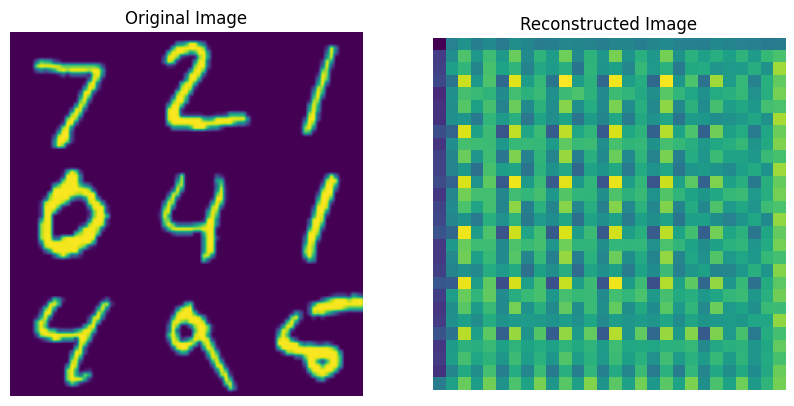

In [30]:
from PIL import Image

# 加载图像
image = Image.open('..\image.png')
# 转换为灰度图像
image = image.convert('L')

import torchvision.transforms as transforms

# 定义转换
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # 将图像调整为模型预期的大小
    transforms.ToTensor(),         # 将图像转换为张量
    transforms.Normalize((0.5,), (0.5,))  # 归一化图像
])

# 应用转换
input_image = transform(image)

import torch

# 将图像添加一个批次维度
input_image = input_image.unsqueeze(0)

# 使用模型进行推理
output_image = model(input_image)

import matplotlib.pyplot as plt

# 可视化原始图像和重建图像
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 显示原始图像
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')

# 显示重建图像
reconstructed_image = output_image.squeeze().detach().numpy()
axes[1].imshow(reconstructed_image, cmap='gray')
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')

plt.show()


训练集大小：60000
测试集大小：10000


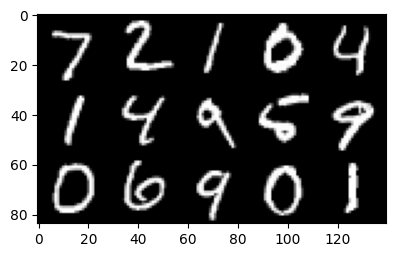

Epoch [1/10], Loss: 0.0042
Epoch [2/10], Loss: 0.0021


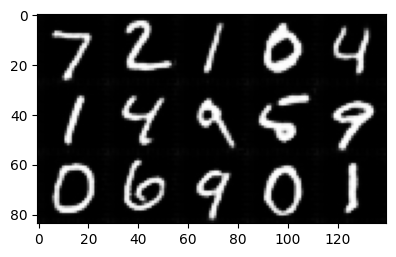

Epoch [3/10], Loss: 0.0014
Epoch [4/10], Loss: 0.0012


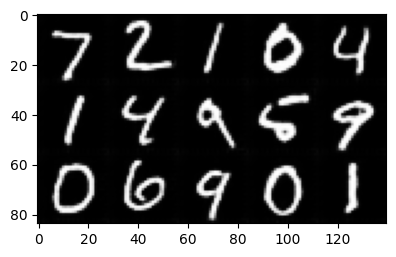

Epoch [5/10], Loss: 0.0011
Epoch [6/10], Loss: 0.0009


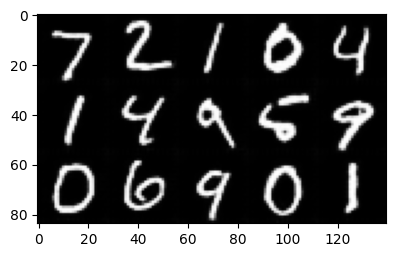

Epoch [7/10], Loss: 0.0008
Epoch [8/10], Loss: 0.0009


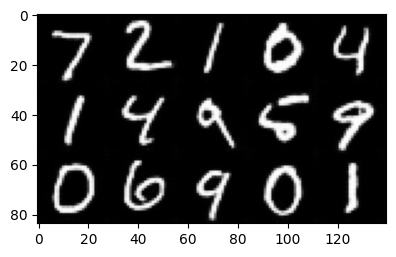

Epoch [9/10], Loss: 0.0007
Epoch [10/10], Loss: 0.0007


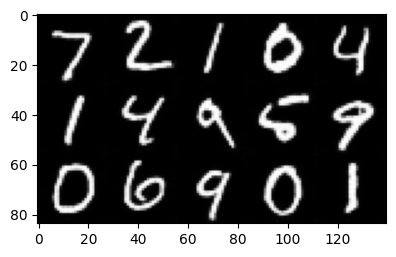

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

# 导入数据
mnist_train = pd.read_csv("..\mnist_train.csv")
mnist_test = pd.read_csv("..\mnist_test.csv")
# 提取出图像信息，并将内容从0~255的整数转换为0.0~1.0的浮点数
# 图像大小为28*28，数组中每一行代表一张图像
x_train = mnist_train.iloc[:, 1:].to_numpy().reshape(-1, 1, 28, 28) / 255
x_test = mnist_test.iloc[:, 1:].to_numpy().reshape(-1, 1, 28, 28) / 255
print(f'训练集大小：{len(x_train)}')
print(f'测试集大小：{len(x_test)}')

def display(data, m, n):
    # data：图像的像素数据，每行代表一张图像
    # m，n：按m行n列的方式展示前m * n张图像
    img = np.zeros((28 * m, 28 * n))
    for i in range(m):
        for j in range(n):
            # 填充第i行j列图像的数据
            img[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = \
                data[i * n + j].reshape(28, 28)
    plt.figure(figsize=(m * 1.5, n * 1.5))
    plt.imshow(img, cmap='gray')
    plt.show()

display(x_test.squeeze(), 3, 5)

# 自动编码器
class AutoencoderCNN(nn.Module):
    def __init__(self):
        super(AutoencoderCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 编码层1
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # 编码层2
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 解码层1
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 解码层2
            nn.Sigmoid()  # 使用Sigmoid激活函数将输出映射到0-1之间
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 实例化自动编码器
autoencoder = AutoencoderCNN()

# 训练超参数
learning_rate = 0.001  # 学习率
max_epoch = 10  # 训练轮数
batch_size = 256  # 批量大小

# 采用Adam优化器
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# 开始训练
for epoch in range(max_epoch):
    # 打乱训练样本
    indices = np.arange(len(x_train))
    np.random.shuffle(indices)
    x_train_shuffled = x_train[indices]

    for i in range(0, len(x_train_shuffled), batch_size):
        # 准备输入数据
        inputs = x_train_shuffled[i:i+batch_size]
        inputs = torch.tensor(inputs, dtype=torch.float32)

        # 前向传播
        outputs = autoencoder(inputs)

        # 计算损失
        loss = criterion(outputs, inputs)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{max_epoch}], Loss: {loss.item():.4f}')

    if (epoch + 1) % 2 == 0:
        # 选取测试集中的部分图像重建并展示
        with torch.no_grad():
            inputs = torch.tensor(x_test[:3 * 5], dtype=torch.float32)
            outputs = autoencoder(inputs)
        display(outputs.squeeze().cpu().numpy(), 3, 5)


训练集大小：60000
测试集大小：10000
Epoch [1/10], Loss: 0.0045
Epoch [2/10], Loss: 0.0020


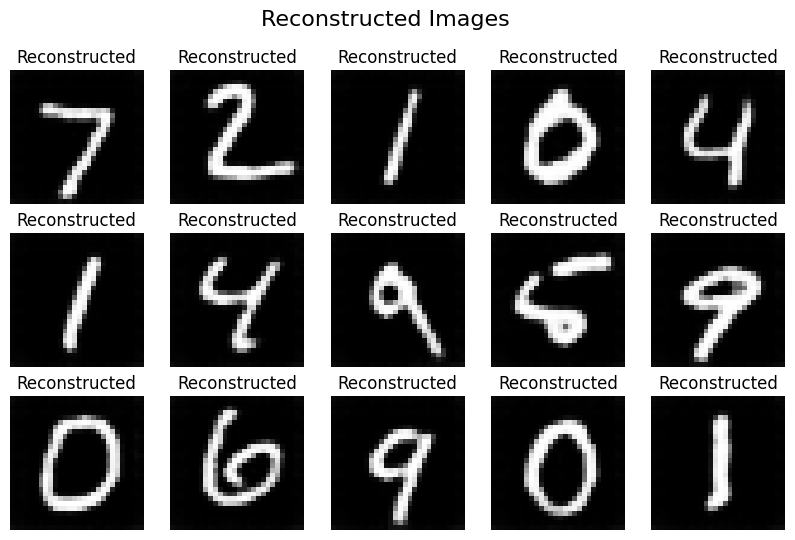

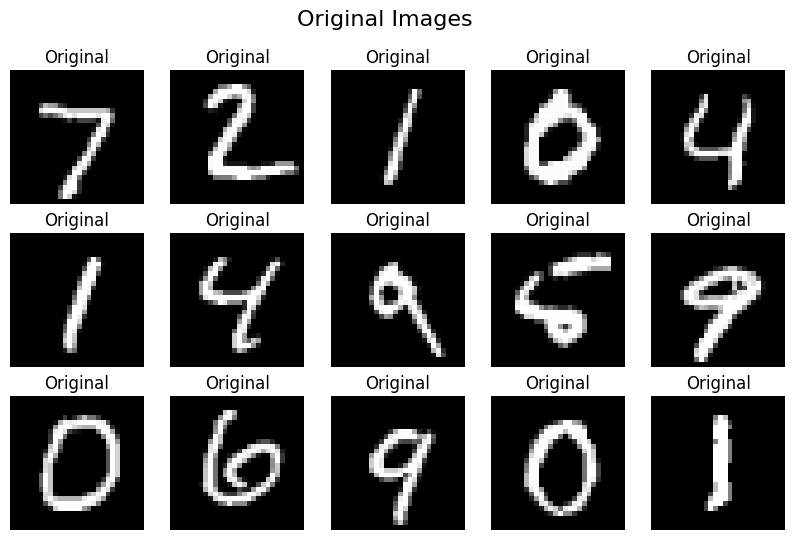

Epoch [3/10], Loss: 0.0015
Epoch [4/10], Loss: 0.0012


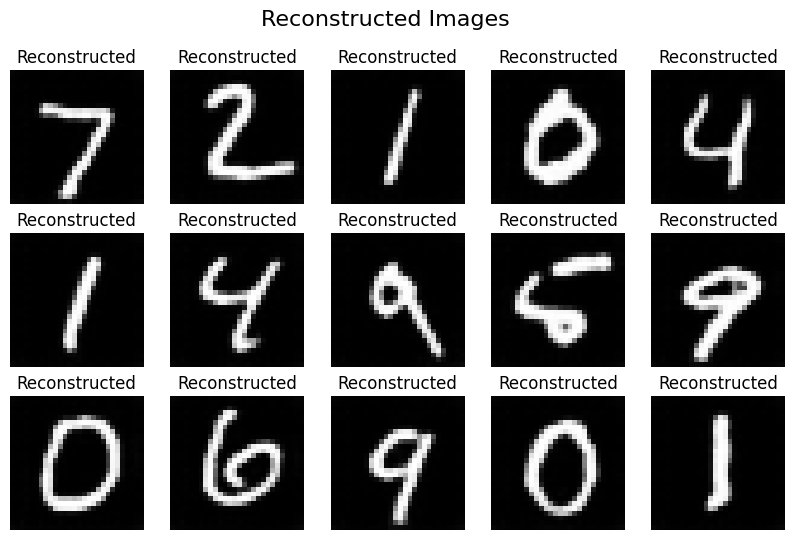

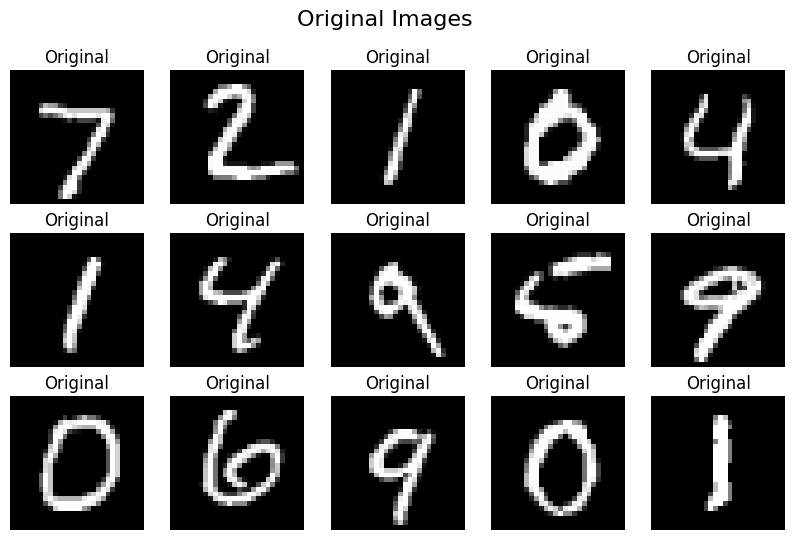

Epoch [5/10], Loss: 0.0011
Epoch [6/10], Loss: 0.0009


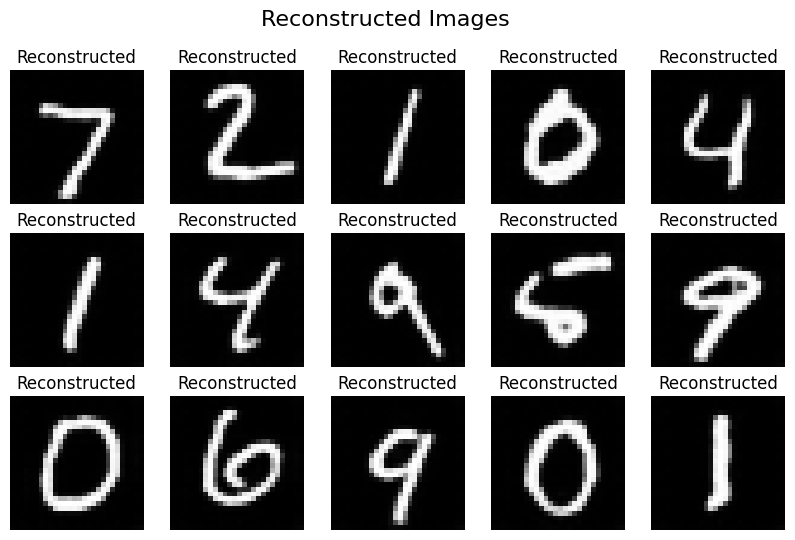

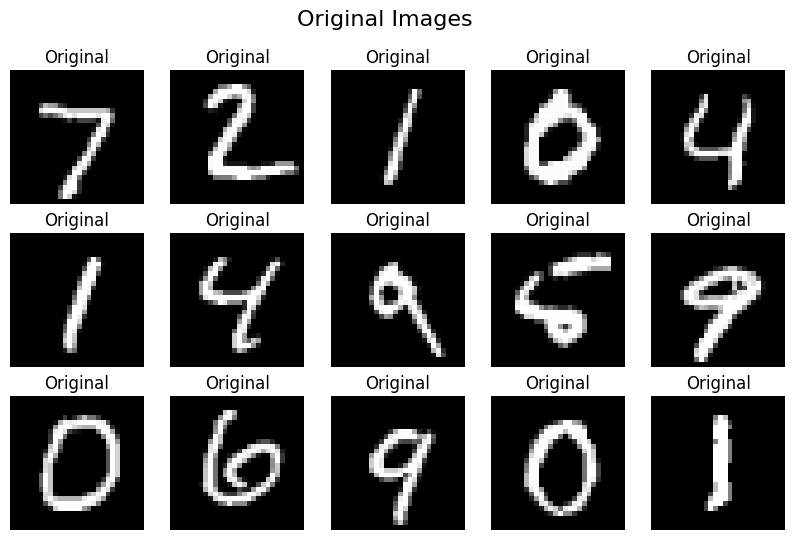

Epoch [7/10], Loss: 0.0009
Epoch [8/10], Loss: 0.0008


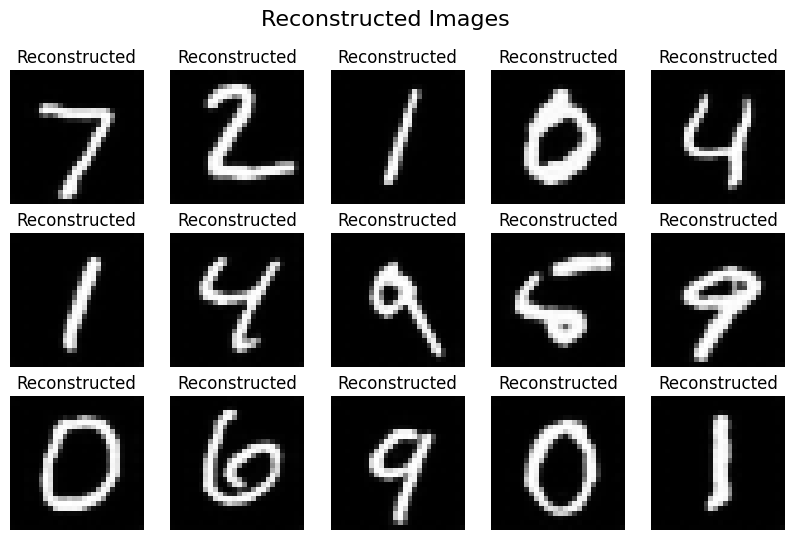

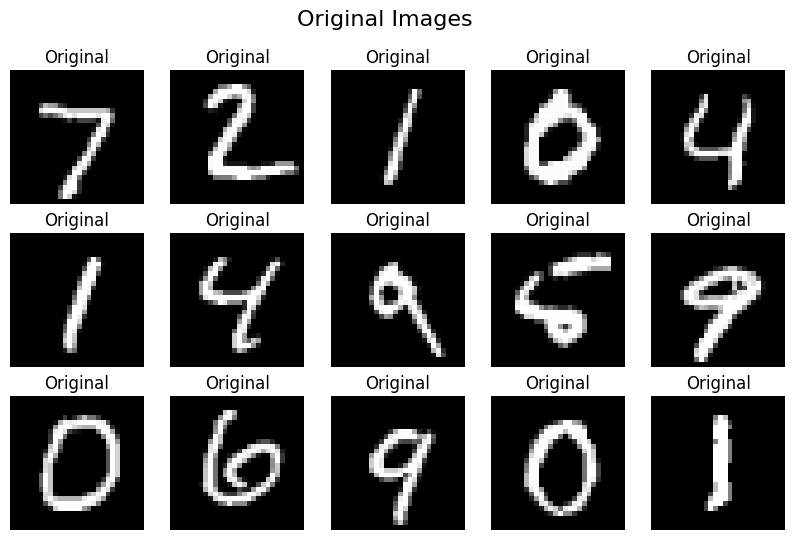

Epoch [9/10], Loss: 0.0008
Epoch [10/10], Loss: 0.0007


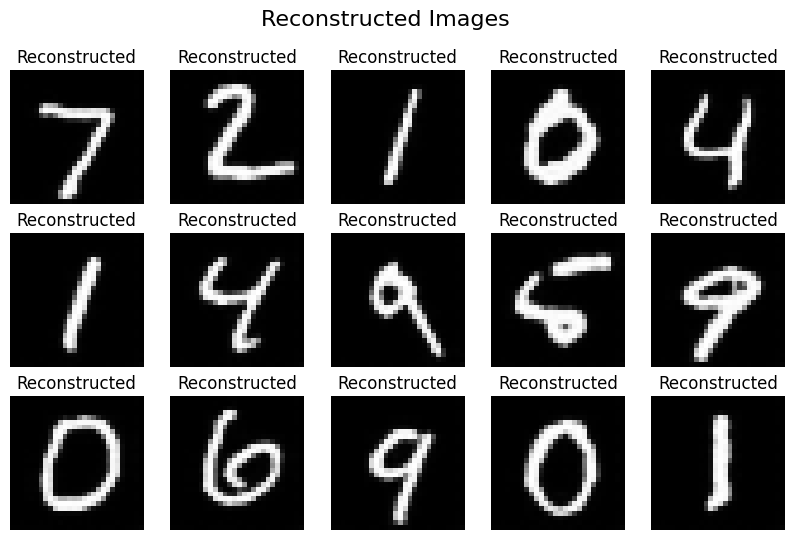

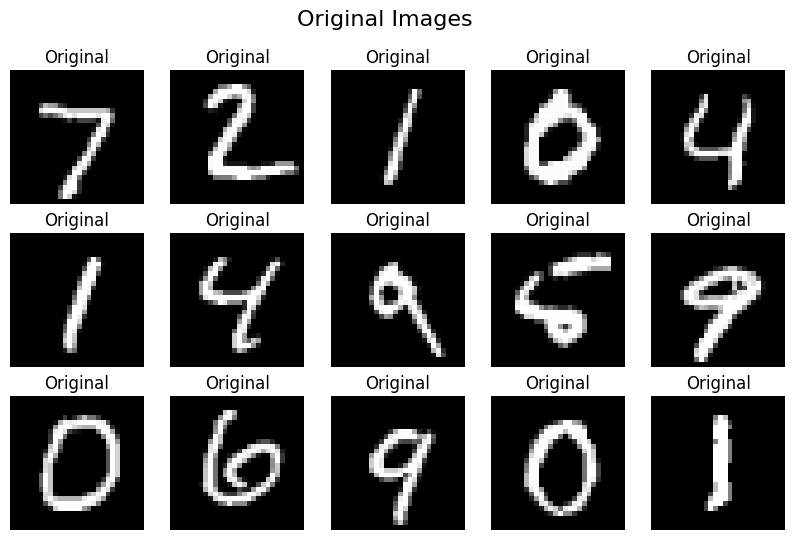

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

# 导入数据
mnist_train = pd.read_csv("../mnist_train.csv")
mnist_test = pd.read_csv("../mnist_test.csv")
# 提取出图像信息，并将内容从0~255的整数转换为0.0~1.0的浮点数
# 图像大小为28*28，数组中每一行代表一张图像
x_train = mnist_train.iloc[:, 1:].to_numpy().reshape(-1, 1, 28, 28) / 255
x_test = mnist_test.iloc[:, 1:].to_numpy().reshape(-1, 1, 28, 28) / 255
print(f'训练集大小：{len(x_train)}')
print(f'测试集大小：{len(x_test)}')

def display(data, original_data, m, n):
    # data：图像的像素数据，每行代表一张图像
    # original_data：原始图像的像素数据，每行代表一张图像
    # m，n：按m行n列的方式展示前m * n张图像
    fig, axes = plt.subplots(m, n, figsize=(n*2, m*2))
    for i in range(m):
        for j in range(n):
            axes[i][j].imshow(data[i * n + j].reshape(28, 28), cmap='gray')
            axes[i][j].axis('off')
            axes[i][j].set_title('Reconstructed')
    fig.suptitle('Reconstructed Images', fontsize=16)
    plt.show()

    fig, axes = plt.subplots(m, n, figsize=(n*2, m*2))
    for i in range(m):
        for j in range(n):
            axes[i][j].imshow(original_data[i * n + j].reshape(28, 28), cmap='gray')
            axes[i][j].axis('off')
            axes[i][j].set_title('Original')
    fig.suptitle('Original Images', fontsize=16)
    plt.show()

# 自动编码器
class AutoencoderCNN(nn.Module):
    def __init__(self):
        super(AutoencoderCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 编码层1
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # 编码层2
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 解码层1
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 解码层2
            nn.Sigmoid()  # 使用Sigmoid激活函数将输出映射到0-1之间
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 实例化自动编码器
autoencoder = AutoencoderCNN()

# 训练超参数
learning_rate = 0.001  # 学习率
max_epoch = 10  # 训练轮数
batch_size = 256  # 批量大小

# 采用Adam优化器
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# 开始训练
for epoch in range(max_epoch):
    # 打乱训练样本
    indices = np.arange(len(x_train))
    np.random.shuffle(indices)
    x_train_shuffled = x_train[indices]

    for i in range(0, len(x_train_shuffled), batch_size):
        # 准备输入数据
        inputs = x_train_shuffled[i:i+batch_size]
        inputs = torch.tensor(inputs, dtype=torch.float32)

        # 前向传播
        outputs = autoencoder(inputs)

        # 计算损失
        loss = criterion(outputs, inputs)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{max_epoch}], Loss: {loss.item():.4f}')

    if (epoch + 1) % 2 == 0:
        # 选取测试集中的部分图像重建并展示
        with torch.no_grad():
            inputs = torch.tensor(x_test[:3 * 5], dtype=torch.float32)
            outputs = autoencoder(inputs)
        display(outputs.squeeze().cpu().numpy(), x_test[:3 * 5].squeeze(), 3, 5)


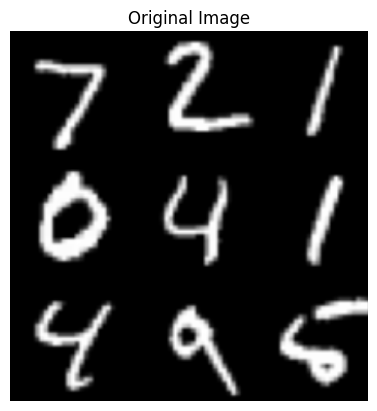

Epoch [1/10], Loss: 0.0775
Epoch [2/10], Loss: 0.0545
Epoch [3/10], Loss: 0.0326
Epoch [4/10], Loss: 0.0184
Epoch [5/10], Loss: 0.0108
Epoch [6/10], Loss: 0.0073
Epoch [7/10], Loss: 0.0062
Epoch [8/10], Loss: 0.0055
Epoch [9/10], Loss: 0.0047
Epoch [10/10], Loss: 0.0044


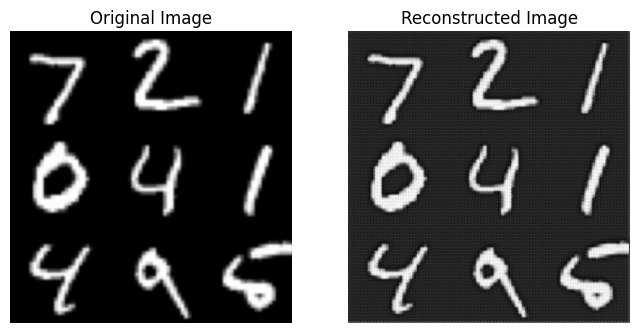

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim

# 加载图像
image = Image.open("..\image.png").convert("L")  # 转换为灰度图像
# image = image.resize((28, 28))  # 调整图像大小为28x28
image = np.array(image) / 255.0  # 归一化到0-1之间

# 显示原始图像
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

# 转换图像为模型输入格式
image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # 添加批次和通道维度

# 自动编码器
class AutoencoderCNN(nn.Module):
    def __init__(self):
        super(AutoencoderCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 编码层1
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # 编码层2
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 解码层1
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 解码层2
            nn.Sigmoid()  # 使用Sigmoid激活函数将输出映射到0-1之间
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 实例化自动编码器
autoencoder = AutoencoderCNN()

# 训练超参数
learning_rate = 0.001  # 学习率
max_epoch = 10  # 训练轮数
batch_size = 256  # 批量大小

# 采用Adam优化器
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# 准备训练数据
# 在这个例子中，不使用真实的图像数据，而是随机生成一些图像数据来作为训练数据
# 实际应用中，需要准备一个真实的数据集来进行训练
num_samples = 10000
train_data = torch.rand(num_samples, 1, 28, 28)

# 开始训练
for epoch in range(max_epoch):
    # 打乱训练样本
    indices = np.arange(len(train_data))
    np.random.shuffle(indices)
    train_data_shuffled = train_data[indices]

    for i in range(0, len(train_data_shuffled), batch_size):
        # 准备输入数据
        inputs = train_data_shuffled[i:i+batch_size]

        # 前向传播
        outputs = autoencoder(inputs)

        # 计算损失
        loss = criterion(outputs, inputs)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{max_epoch}], Loss: {loss.item():.4f}')

# 前向传播并重建图像
with torch.no_grad():
    reconstructed_image = autoencoder(image_tensor)

# 转换张量为NumPy数组并去除批次和通道维度
reconstructed_image = reconstructed_image.squeeze().cpu().numpy()

# 显示原始图像和重建图像
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

plt.show()


---

4. 降噪编码器是自动编码器的一个变种，它主动为输入样本添加噪声，将带噪的样本给自动编码器训练，与原始样本计算重建损失。这样训练出的自动编码器就有了去噪功能。试给手写数字图像加上噪声，用降噪编码器为其去噪，观察去噪后的图像与原始图像的区别。

Epoch [1/10], Loss: 0.0418
Epoch [2/10], Loss: 0.0202
Epoch [3/10], Loss: 0.0160
Epoch [4/10], Loss: 0.0141
Epoch [5/10], Loss: 0.0128
Epoch [6/10], Loss: 0.0119
Epoch [7/10], Loss: 0.0111
Epoch [8/10], Loss: 0.0106
Epoch [9/10], Loss: 0.0101
Epoch [10/10], Loss: 0.0098


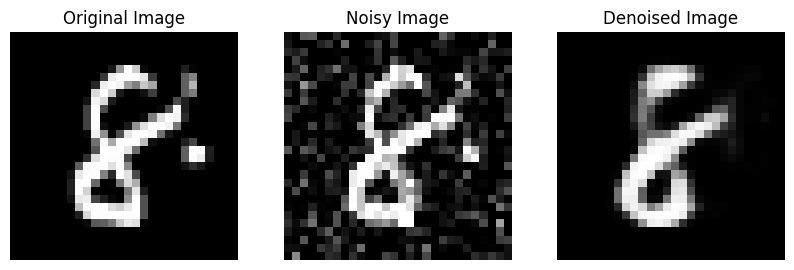

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 加载数据集
mnist_train = pd.read_csv("..\mnist_train.csv")
mnist_test = pd.read_csv("..\mnist_test.csv")

# 提取特征和标签
x_train = mnist_train.iloc[:, 1:].to_numpy() / 255.0
y_train = mnist_train.iloc[:, 0].to_numpy()

x_test = mnist_test.iloc[:, 1:].to_numpy() / 255.0
y_test = mnist_test.iloc[:, 0].to_numpy()

# 将数据转换为张量格式
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

# 定义降噪函数，添加高斯噪声
def add_noise(data, noise_factor=0.2):
    noise = torch.randn_like(data) * noise_factor
    noisy_data = data + noise
    return torch.clamp(noisy_data, 0., 1.)  # 将数据截断在 [0, 1] 范围内

# 自动编码器
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 实例化模型
model = DenoisingAutoencoder()

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 定义训练函数
def train(model, dataloader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for data in dataloader:
            inputs, _ = data
            noisy_inputs = add_noise(inputs)
            optimizer.zero_grad()
            outputs = model(noisy_inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

# 将数据封装成 DataLoader
train_dataset = TensorDataset(x_train_tensor, torch.tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 训练模型
train(model, train_loader, criterion, optimizer)

# 随机选取一张图像进行测试
index = np.random.randint(len(x_test))
test_image = x_test_tensor[index]
noisy_test_image = add_noise(test_image.unsqueeze(0))

# 使用训练好的模型对噪声图像进行去噪
with torch.no_grad():
    denoised_image = model(noisy_test_image).squeeze()

# 可视化原始图像、噪声图像和去噪图像
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.imshow(test_image.view(28, 28), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(noisy_test_image.view(28, 28), cmap='gray')
plt.title('Noisy Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(denoised_image.view(28, 28), cmap='gray')
plt.title('Denoised Image')
plt.axis('off')

plt.show()
